### k-DPP MCMC sampling

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from dpp import QualityMapClass,kdpp,ikdpp,add_colorbar,kernel_se
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
print ("Packages loaded.")

Packages loaded.


### Get measurement

n_total:[2000] n_select:[100] 


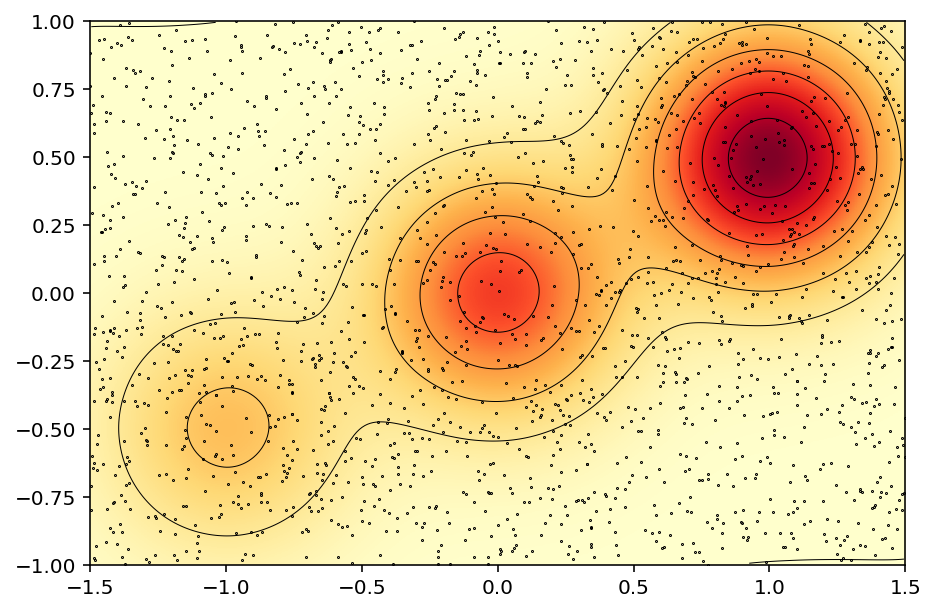

In [2]:
np.random.seed(seed=0)
n_total           = 2000
n_select          = 100
n_remain          = n_total - n_select
hyp               = {'g':1.0,'l':0.5}
QM                = QualityMapClass()
xs_total,qs_total = QM.get_meas(n_meas=n_total)
print ("n_total:[%d] n_select:[%d] "%(n_total,n_select))

# Plot
plt.figure(figsize = (10,5))
plt.rcParams.update({'font.size':10})
im = plt.imshow(X      = QM.Q,
                extent = QM.axis_info,
                cmap   = 'YlOrRd',
                origin = 'lower')
plt.contour(QM.Q,
            extent     = QM.axis_info,
            origin     = 'lower',
            colors     = 'k',
            linewidths = 1/2)
plt.plot(xs_total[:,0],xs_total[:,1],'.',mfc='none',mec='k',ms=1,lw=1/2)
plt.show()

### k-DPP MCMC
Replacement probability is given by:
$$
\frac{1}{2} \min \left( 1, \frac{\mu(T)}{\mu(S)} \right)
$$

In [3]:
# First select k items
idxs_perm   = np.random.permutation(n_total)
idxs_select = idxs_perm[:n_select]
idxs_remain = idxs_perm[n_select:]

# Loop
# Backup
idxs_select_prev = np.copy(idxs_select)
idxs_remain_prev = np.copy(idxs_remain)
idxs_selects = []
max_tick     = 1000
for tick in range(max_tick):
    
    # Current (unnormalized) measure of the selected ones
    x_curr  = xs_total[idxs_select,:]
    K_curr  = kernel_se(x_curr,x_curr,hyp=hyp)
    K_curr  = K_curr + 1.0*np.diag(qs_total[idxs_select])
    mu_curr = np.linalg.det(K_curr)
    
    # Make a replacement in both x and q
    idx_in_select = np.random.randint(n_select)
    idx_in_remain = np.random.randint(n_remain)
    idx_buffer    = idxs_select[idx_in_select]
    idxs_select[idx_in_select] = idxs_remain[idx_in_remain]
    idxs_remain[idx_in_remain] = idx_buffer
    
    # Next (unnormalized) measure of the selected ones
    x_next  = xs_total[idxs_select,:]
    K_next  = kernel_se(x_next,x_next,hyp=hyp)
    K_next  = K_next + 1.0*np.diag(qs_total[idxs_select])
    mu_next = np.linalg.det(K_next)
    
    # Replace with prob
    prob = 0.5*min(1.0,mu_next/mu_curr) # ths higher the more chances of improvement
    MODE = 'replaced'
    if np.random.rand(1)[0] > prob:     # revert probaility
        idxs_select = np.copy(idxs_select_prev)
        idxs_remain = np.copy(idxs_remain_prev)
        MODE = 'remained'
        
    # Backup
    idxs_select_prev = np.copy(idxs_select)
    idxs_remain_prev = np.copy(idxs_remain)
    
    # Append
    idxs_selects.append(idxs_select)
    
    # Print
    if ((tick%500)==0) or (tick==(max_tick-1)):
        print ("[%d] mu_curr:[%.2e] mu_next:[%.2e] prob:[%.2f] [%s]"%
               (tick,mu_curr,mu_next,prob,MODE))
        
print ("Done.")

[0] mu_curr:[6.48e-76] mu_next:[2.84e-76] prob:[0.22] [remained]
[500] mu_curr:[2.45e-43] mu_next:[6.70e-44] prob:[0.14] [remained]
[999] mu_curr:[1.13e-31] mu_next:[1.19e-30] prob:[0.50] [replaced]
Done.


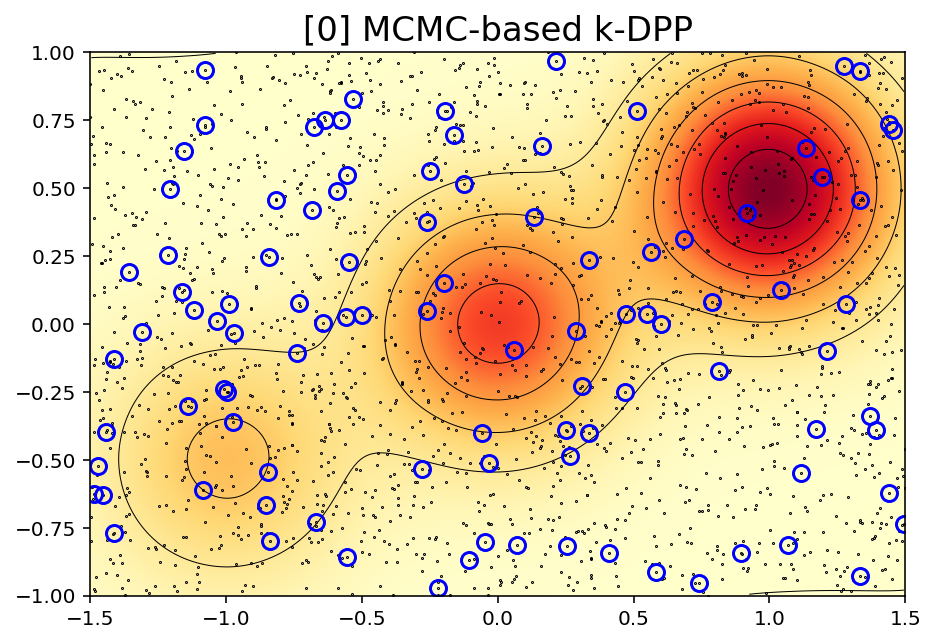

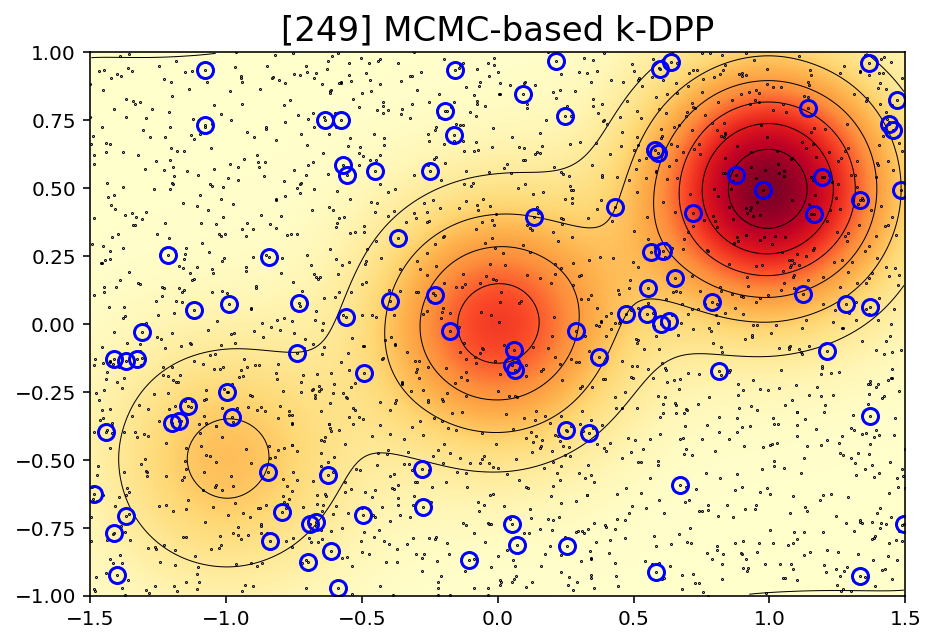

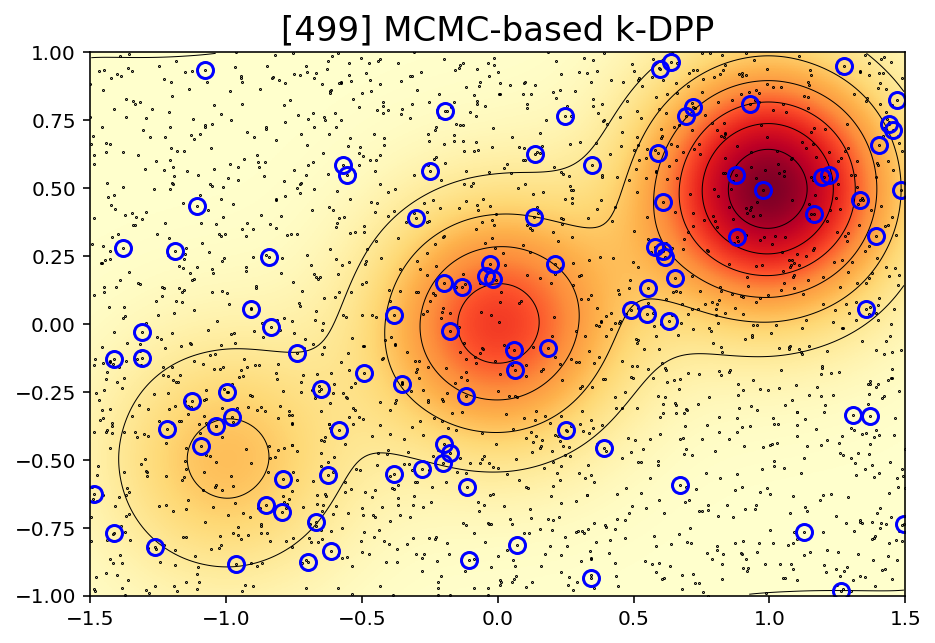

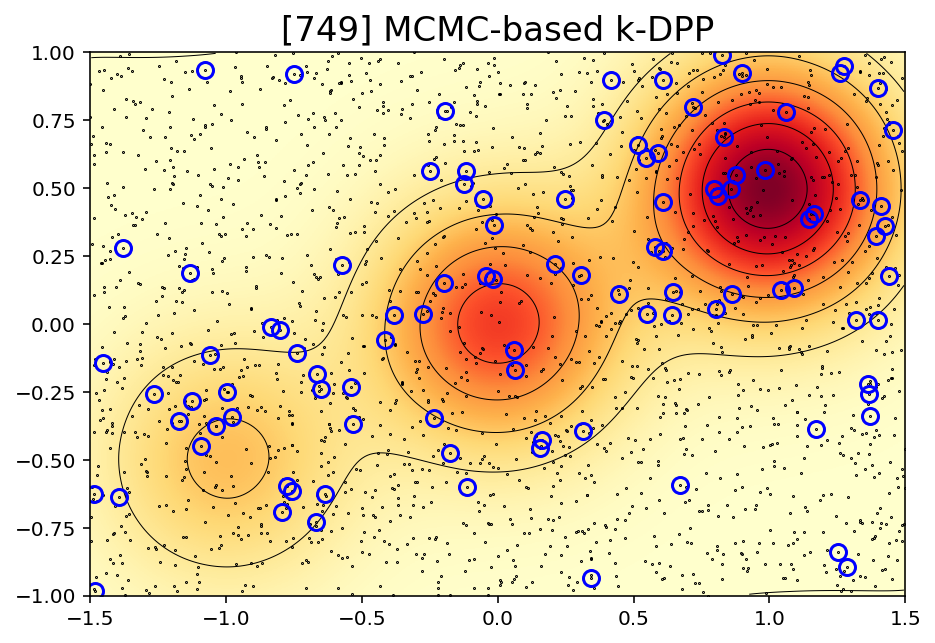

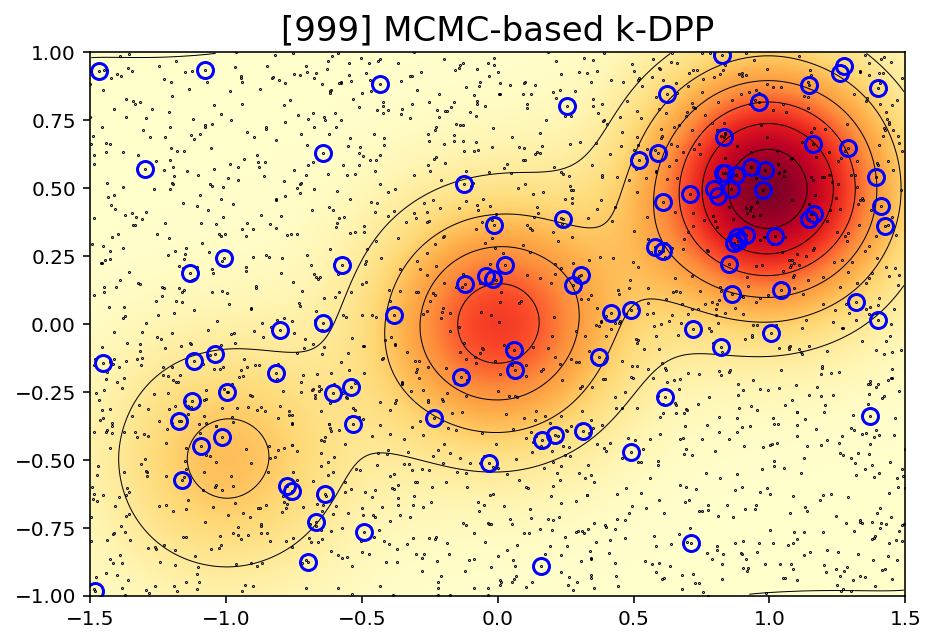

In [15]:
# Plots
for tick in np.linspace(start=0,stop=(max_tick-1),num=5).astype(np.int32):
    plt.figure(figsize = (10,5))
    plt.rcParams.update({'font.size':10})
    im = plt.imshow(X      = QM.Q,
                    extent = QM.axis_info,
                    cmap   = 'YlOrRd',
                    origin = 'lower')
    plt.contour(QM.Q,
                extent     = QM.axis_info,
                origin     = 'lower',
                colors     = 'k',
                linewidths = 1/2)
    plt.plot(xs_total[:,0],xs_total[:,1],'.',mfc='none',mec='k',ms=1,lw=1/2)
    idxs_select = idxs_selects[tick]
    plt.plot(xs_total[idxs_select,0],xs_total[idxs_select,1],
             'o',mfc='none',mec=[0.0,0.0,1.0],ms=8,mew=1.5)
    plt.title("[%d] MCMC-based k-DPP"%(tick),fontsize=17)
    plt.show()